<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#hide" data-toc-modified-id="hide-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>hide</a></span></li><li><span><a href="#Model" data-toc-modified-id="Model-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Model</a></span></li><li><span><a href="#Model-2" data-toc-modified-id="Model-2-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Model 2</a></span></li></ul></div>

In [1]:
import numpy as np

import torch
from torch import nn, optim
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data.dataset import random_split
from torch.utils.data import DataLoader
import torch.nn.functional as F

from torchaudio import datasets

E:\Users\alex\anaconda3\envs\mil\lib\site-packages\torchaudio\extension\extension.py:14: UserWarning: torchaudio C++ extension is not available.
  warnings.warn('torchaudio C++ extension is not available.')
E:\Users\alex\anaconda3\envs\mil\lib\site-packages\torchaudio\backend\utils.py:64: UserWarning: The interface of "soundfile" backend is planned to change in 0.8.0 to match that of "sox_io" backend and the current interface will be removed in 0.9.0. To use the new interface, do `torchaudio.USE_SOUNDFILE_LEGACY_INTERFACE = False` before setting the backend to "soundfile". Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  'The interface of "soundfile" backend is planned to change in 0.8.0 to '


In [2]:
import util
import layers

In [3]:
print(torch.cuda.is_available())

True


In [4]:
dev = torch.device(
    "cuda") if torch.cuda.is_available() else torch.device("cpu")

In [5]:
import IPython.display as ipd

In [6]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
dataset = datasets.VCTK_092(root="data", download=False)

In [7]:
ds_size = len(dataset)
train_i = int(0.01*ds_size)
val_i = int(0.011*ds_size) - train_i
test_i = ds_size - train_i - val_i
train_i, val_i, test_i, train_i + val_i + test_i == ds_size

(438, 44, 43391, True)

In [8]:
train_ds, val_ds, test_ds = random_split(dataset, lengths=[train_i, val_i, test_i],
                                         generator=torch.Generator().manual_seed(42))

In [9]:
sr = 48000

In [10]:
def pad_collate(batch):
    (xx, _, _, _, _) = zip(*batch)
    xx = [x.squeeze() for x in xx]
#     print(xx[0].shape)
    xx_pad = pad_sequence(xx, batch_first=True, padding_value=0).unsqueeze(1)
#     print(xx_pad.shape)

    return xx_pad

### hide

In [176]:
# bs = 32
# train_dl, val_dl, test_dl = (DataLoader(train_ds, batch_size=bs, collate_fn=pad_collate), 
#                              DataLoader(val_ds, batch_size=bs, collate_fn=pad_collate), 
#                              DataLoader(test_ds, batch_size=bs, collate_fn=pad_collate))

In [20]:
x, sr, text, _, _ = train_ds[0]
print(text)

A Foreign Office spokesman declined to comment.



In [21]:
display(ipd.Audio(x, rate=sr));

In [192]:
conv_1 = nn.Conv1d(in_channels=1, out_channels=32, kernel_size=2048, stride=512, padding=1023, bias=True)
deconv_1 = nn.ConvTranspose1d(in_channels=32, out_channels=1, kernel_size=2048, stride=512, padding=1023, bias=True)

In [211]:
ii = iter(train_dl)
x = next(ii)
x.shape

torch.Size([32, 1, 563610])

In [225]:
y = torch.zeros(x.shape)
y_ = deconv_1(conv_1(x))
i, j, k = y_.shape
y[:i, :j, :k] = y_
y_.shape
x.narrow(2, 0, y_.shape[2]).shape, y_.shape

(torch.Size([32, 1, 563202]), torch.Size([32, 1, 563202]))

In [204]:
m = nn.ZeroPad2d((32, 1, 301286))

In [205]:
m(y)

AssertionError: Padding length must be divisible by 2

### Model

In [11]:
loss_func = nn.L1Loss() #F.l1_loss#F.mse_loss

Trivial Convlolutional Audio Denoising AutoEncoder

In [12]:
cc=1e1
class TrivialCADAE(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_1 = nn.Conv1d(in_channels=1, out_channels=32, kernel_size=2048, stride=512, padding=1023, bias=True)
        self.deconv_1 = nn.ConvTranspose1d(in_channels=32, out_channels=1, kernel_size=2048, stride=512, padding=1023, bias=True)
        
    def encoder(self, x):
        y = torch.tanh(self.conv_1(x))
        return y
      
    def decoder(self, y):
        x_hat = self.deconv_1(y)
        return x_hat

    def forward(self, x):
        y = self.encoder(x)
        x_hat = self.decoder(y)
        return x_hat

def loss_batch(model, loss_func, x, y, opt=None):
    x_hat = model(x).unsqueeze(1)
#     print(x_hat.shape, y.shape)
    loss = loss_func(x_hat, y.narrow(2, 0, x_hat.shape[2]))

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(), x.shape[0]

def fit(epochs, model, loss_func, opt, train_dl, val_dl):
    train_size = train_i
    for epoch in range(epochs):
        model.train()
        for batch_idx, (x, y) in enumerate(train_dl):
            _loss, _len = loss_batch(model, loss_func, x, y, opt)
            
            if batch_idx % 20 == 19:
                line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
                    epoch, batch_idx * bs, train_size, 100. * batch_idx / len(train_dl))
                losses = '{}: {:.10f}'.format("Trivial", _loss / _len*cc)
                print(line + losses)

#     else:
        batch_idx += 1
        line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
            epoch, min(batch_idx * bs, train_size), train_size, 100. * batch_idx / len(train_dl))
        losses = '{}: {:.10f}'.format("Trivial", _loss / _len*cc)
        print(line + losses)

        model.eval()
        with torch.no_grad():
            losses, nums = zip(
                *[loss_batch(model, loss_func, x, y) for (x, y) in val_dl]
            )
        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)*cc

        print("Validation Epoch: {}\tLosses {}: {:.10f}".format("Trivial", epoch, val_loss))
        
def get_data(train_ds, val_ds, test_ds, bs):
    return (
         DataLoader(train_ds, batch_size=bs, collate_fn=pad_collate, shuffle=True), 
         DataLoader(val_ds, batch_size=2 * bs, collate_fn=pad_collate), 
         DataLoader(test_ds, batch_size=2 * bs, collate_fn=pad_collate),
    )

def get_model():
    model = TrivialCADAE()
    model.to(dev)
    return model, optim.Adam(model.parameters())

def preprocess(x):
    return x.to(dev)

class WrappedDataLoader:
    def __init__(self, dl, func):
        self.dl = dl
        self.func = func

    def __len__(self):
        return len(self.dl)

    def __iter__(self):
        batches = iter(self.dl)
        for b in batches:
            inter = torch.stft(b.squeeze(), n_fft=2048, return_complex=True)
#             inter.shape, inter.shape[0]*inter.shape[1]
#             print(inter.shape)

            d0 = torch.randint(inter.shape[0], (1, 500000))
            d1 = torch.randint(inter.shape[1], (1, 500000))
            d2 = torch.randint(inter.shape[2], (1, 500000))
            ll = torch.cat((d0, d1, d2)).numpy()
#             print(ll)
            inter[ll] = 0
#             waveform_n = torch.istft(inter, n_fft=512)

#             ll = torch.randint(min(inter.shape[1], inter.shape[2]), (2, 100))
#             inter[ll] = 0

#             ll0 = [(0, 
#                     np.random.randint(0, inter.shape[1]),
#                     np.random.randint(0, inter.shape[2])) for i in range(200000)]
    
#             ll1 = [(1, 
#                     np.random.randint(0, inter.shape[1]),
#                     np.random.randint(0, inter.shape[2])) for i in range(200000)]

#             inter[list(zip(*ll0))] = 0
#             inter[list(zip(*ll1))] = 0
            
#             for i in range(100000):
#                 i, j = np.random.randint(0, inter.shape[1]), np.random.randint(0, inter.shape[2])
#                 inter[0, i, j] = 0
#                 inter[1, i, j] = 0
            x = torch.istft(inter, n_fft=2048)
            yield (self.func(x.unsqueeze(1)), self.func(b))
#             yield (self.func(b))

In [13]:
bs = 32
train_dl, val_dl, test_dl = get_data(train_ds, val_ds, test_ds, bs)
train_dl = WrappedDataLoader(train_dl, preprocess)
val_dl = WrappedDataLoader(val_dl, preprocess)
test_dl = WrappedDataLoader(test_dl, preprocess)
model, opt = get_model()

In [15]:
fit(10, model, loss_func, opt, train_dl, val_dl)

E:\Users\alex\anaconda3\envs\mil\lib\site-packages\torch\nn\modules\loss.py:94: UserWarning: Using a target size (torch.Size([32, 1, 1])) that is different to the input size (torch.Size([32, 1, 1, 254978])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
E:\Users\alex\anaconda3\envs\mil\lib\site-packages\torch\nn\modules\loss.py:94: UserWarning: Using a target size (torch.Size([32, 1, 1])) that is different to the input size (torch.Size([32, 1, 1, 407042])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
E:\Users\alex\anaconda3\envs\mil\lib\site-packages\torch\nn\modules\loss.py:94: UserWarning: Using a target size (torch.Size([32, 1, 1])) that is different to the input size (torch.Size([32, 1, 1, 332290])). This will likely lead to incorrect results due to 

KeyboardInterrupt: 

In [460]:
torch.save(model.state_dict(), "trivial.pth")

In [38]:
x = val_ds[0][0]
display(ipd.Audio(x, rate=sr));

In [469]:
net = TrivialCADAE()
net.load_state_dict(torch.load("trivial.pth"))

<All keys matched successfully>

In [39]:
y = net(x.unsqueeze(1)).squeeze(1).detach().numpy()
display(ipd.Audio(y, rate=sr));

In [31]:
import matplotlib.pyplot as plt

In [32]:
x.shape, y.shape

NameError: name 'x' is not defined

In [33]:
plt.figure(figsize=(15, 10))
# plt.plot(y.T)
plt.plot(x.t().numpy())
plt.plot(y.T)

NameError: name 'x' is not defined

<Figure size 1080x720 with 0 Axes>

In [390]:
x.t().numpy().shape

(249076, 1)

In [391]:
y.shape

(1, 248834)

### Model 2

In [13]:
config = {
    "dataset": {
        "extract_voice": True,
        "in_memory_percentage": 1,
        "noise_only_percent": 0.1,
        "num_condition_classes": 29,
        "path": "data/NSDTSEA/",
        "regain": 0.06,
        "sample_rate": 16000,
        "type": "nsdtsea"
    },
    "model": {
        "condition_encoding": "binary",
        "dilations": 9,
        "filters": {
            "lengths": {
                "res": 3,
                "final": [3, 3],
                "skip": 1
            },
            "depths": {
                "res": 128,
                "skip": 128,
                "final": [2048, 256]
            }
        },
        "num_stacks": 3,
        "target_field_length": 1601,
        "target_padding": 1
    },
    "optimizer": {
        "decay": 0.0,
        "epsilon": 1e-08,
        "lr": 0.001,
        "momentum": 0.9,
        "type": "adam"
    },
    "training": {
        "batch_size": 10,
        "early_stopping_patience": 16,
        "loss": {
            "out_1": {
                "l1": 1,
                "l2": 0,
                "weight": 1
            },
            "out_2": {
                "l1": 1,
                "l2": 0,
                "weight": 1
            }
        },
        "num_epochs": 250,
        "num_test_samples": 100,
        "num_train_samples": 1000,
        "path": "data/NSDTSEA/"
    }
}

In [13]:
config = {
    "dataset": {
        "extract_voice": True,
        "in_memory_percentage": 1,
        "noise_only_percent": 0.1,
        "num_condition_classes": 29,
        "path": "data/NSDTSEA/",
        "regain": 0.06,
        "sample_rate": 16000,
        "type": "nsdtsea"
    },
    "model": {
        "condition_encoding": "binary",
        "dilations": 6,
        "filters": {
            "lengths": {
                "res": 3,
                "final": [3, 3],
                "skip": 1
            },
            "depths": {
                "res": 16,
                "skip": 16,
                "final": [256, 32]
            }
        },
        "num_stacks": 2,
        "target_field_length": 1601,
        "target_padding": 1
    },
    "optimizer": {
        "decay": 0.0,
        "epsilon": 1e-08,
        "lr": 0.001,
        "momentum": 0.9,
        "type": "adam"
    },
    "training": {
        "batch_size": 10,
        "early_stopping_patience": 16,
        "loss": {
            "out_1": {
                "l1": 1,
                "l2": 0,
                "weight": 1
            },
            "out_2": {
                "l1": 1,
                "l2": 0,
                "weight": 1
            }
        },
        "num_epochs": 250,
        "num_test_samples": 100,
        "num_train_samples": 1000,
        "path": "data/NSDTSEA/"
    }
}

In [14]:
class dilated_residual_block(nn.Module):
    
    def __init__(self, dilation, input_length, padded_target_field_length, config):
        super().__init__()
        self.dilation =  dilation
        self.input_length = input_length
#         self.condition_input_length = condition_input_length
#         self.samples_of_interest_indices = samples_of_interest_indices
        self.padded_target_field_length = padded_target_field_length
        self.config = config
        self.conv1 = nn.Conv1d(self.config['model']['filters']['depths']['res'], 2*self.config['model']['filters']['depths']['res'],
                               kernel_size = self.config['model']['filters']['lengths']['res'], stride=1, bias = False, dilation = self.dilation,
                               padding=int(self.dilation))
        self.conv2 = nn.Conv1d(self.config['model']['filters']['depths']['res'], 
                               self.config['model']['filters']['depths']['res'] + self.config['model']['filters']['depths']['skip'],
                               1, stride=1, bias = False, padding=0)
        
    
    def forward(self, data_x):

        original_x = data_x

        # Data sub-block
        data_out = self.conv1(data_x)

        data_out_1 = layers.slicing(data_out, slice(0, self.config['model']['filters']['depths']['res'],1), 1) 

        data_out_2 = layers.slicing(data_out, slice(self.config['model']['filters']['depths']['res'], 
                                                    2*self.config['model']['filters']['depths']['res'],1), 1)

        data_out_1 = data_out_1
        
        data_out_2 = data_out_2

        tanh_out = torch.tanh(data_out_1)
        sigm_out = torch.sigmoid(data_out_2)

        data_x = tanh_out*sigm_out

        data_x = self.conv2(data_x)

        res_x = layers.slicing(data_x, slice(0, self.config['model']['filters']['depths']['res'],1), 1)
        
        skip_x = layers.slicing(data_x, slice(self.config['model']['filters']['depths']['res'], 
                                self.config['model']['filters']['depths']['res']+self.config['model']['filters']['depths']['skip'],1), 1)

        res_x = res_x + original_x

        return res_x, skip_x

In [15]:
class DenoisingWavenet(nn.Module):

    def __init__(self, config, input_length=None, target_field_length=None):
        super().__init__()

        self.config = config
        self.num_stacks = self.config['model']['num_stacks']
        if type(self.config['model']['dilations']) is int:
            self.dilations = [2 ** i for i in range(0, self.config['model']['dilations'] + 1)]
        elif type(self.config['model']['dilations']) is list:
            self.dilations = self.config['model']['dilations']

        self.receptive_field_length = util.compute_receptive_field_length(config['model']['num_stacks'], self.dilations, config['model']['filters']['lengths']['res'], 1)

        if input_length is not None:
            self.input_length = int(input_length)
            self.target_field_length = int(self.input_length - (self.receptive_field_length - 1))
        if target_field_length is not None:
            self.target_field_length = int(target_field_length)
            self.input_length = int(self.receptive_field_length + (self.target_field_length - 1))
        else:
            self.target_field_length = int(config['model']['target_field_length'])
            self.input_length = int(self.receptive_field_length + (self.target_field_length - 1))

        self.target_padding = config['model']['target_padding']
        self.padded_target_field_length = self.target_field_length + 2 * self.target_padding
        self.half_target_field_length = int(self.target_field_length / 2)
        self.half_receptive_field_length = int(self.receptive_field_length / 2)
        self.num_residual_blocks = len(self.dilations) * self.num_stacks

        self.config['model']['num_residual_blocks'] = self.num_residual_blocks
        self.config['model']['receptive_field_length'] = self.receptive_field_length
        self.config['model']['input_length'] = self.input_length
        self.config['model']['target_field_length'] = self.target_field_length
        
        # Layers in the model
        self.conv1 = nn.Conv1d(1, self.config['model']['filters']['depths']['res'], self.config['model']['filters']['lengths']['res'], stride=1, bias = False, padding=1)
        
        self.conv2 = nn.Conv1d(self.config['model']['filters']['depths']['res'], self.config['model']['filters']['depths']['final'][0], self.config['model']['filters']['lengths']['final'][0], stride=1, bias = False, padding=1)
        
        self.conv3 = nn.Conv1d(self.config['model']['filters']['depths']['final'][0], self.config['model']['filters']['depths']['final'][1], self.config['model']['filters']['lengths']['final'][1], stride=1, bias = False, padding=1)
        
        self.conv4 = nn.Conv1d(self.config['model']['filters']['depths']['final'][1], 1, 1, stride=1, bias = False, padding=0)
        
        self.dilated_layers = nn.ModuleList([dilated_residual_block(dilation, self.input_length, self.padded_target_field_length, self.config) for dilation in self.dilations])


    def get_target_field_indices(self):

        target_sample_index = self.get_target_sample_index()

        return range(target_sample_index - self.half_target_field_length,
                     target_sample_index + self.half_target_field_length + 1)

    def get_padded_target_field_indices(self):

        target_sample_index = self.get_target_sample_index()

        return range(target_sample_index - self.half_target_field_length - self.target_padding,
                     target_sample_index + self.half_target_field_length + self.target_padding + 1)

    def get_target_sample_index(self):
        return int(np.floor(self.input_length / 2.0))

    def get_condition_input_length(self, representation):

        if representation == 'binary':
            return int(np.ceil(np.log2(self.num_condition_classes)))
        else:
            return self.num_condition_classes

    def forward(self, x):

        data_input = x#['data_input']

        data_expanded = data_input#layers.expand_dims(data_input, 1)
        
        data_out = self.conv1(data_expanded)

        skip_connections = []
        for _ in range(self.num_stacks):
            for layer in self.dilated_layers:
                data_out, skip_out = layer(data_out)
                if skip_out is not None:
                    skip_connections.append(skip_out)

        data_out = torch.stack( skip_connections, dim = 0).sum(dim = 0)
        data_out = F.relu(data_out)

        data_out = self.conv2(data_out)

        data_out = F.relu(data_out)
        
        data_out = self.conv3(data_out)

        data_out = self.conv4(data_out)

        data_out_speech = data_out
        data_out_noise = data_input - data_out_speech

        data_out_speech = data_out_speech.squeeze_(1)

        data_out_noise = data_out_noise.squeeze_(1)

        return data_out_speech#, data_out_noise

In [16]:
model = DenoisingWavenet(config).to(dev)
opt = optim.Adam(model.parameters())
loss_fun = nn.L1Loss()

In [17]:
bs = 2
train_dl, val_dl, test_dl = get_data(train_ds, val_ds, test_ds, bs)
train_dl = WrappedDataLoader(train_dl, preprocess)
val_dl = WrappedDataLoader(val_dl, preprocess)
test_dl = WrappedDataLoader(test_dl, preprocess)
# model, opt = get_model()

In [19]:
from torchsummary import summary
summary(model, (1,10000))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1            [-1, 16, 10000]              48
            Conv1d-2            [-1, 32, 10000]           1,536
            Conv1d-3            [-1, 32, 10000]             512
dilated_residual_block-4  [[-1, 16, 10000], [-1, 16, 10000]]               0
            Conv1d-5            [-1, 32, 10000]           1,536
            Conv1d-6            [-1, 32, 10000]             512
dilated_residual_block-7  [[-1, 16, 10000], [-1, 16, 10000]]               0
            Conv1d-8            [-1, 32, 10000]           1,536
            Conv1d-9            [-1, 32, 10000]             512
dilated_residual_block-10  [[-1, 16, 10000], [-1, 16, 10000]]               0
           Conv1d-11            [-1, 32, 10000]           1,536
           Conv1d-12            [-1, 32, 10000]             512
dilated_residual_block-13  [[-1, 16, 10000], [-1, 16, 10000]]  

In [19]:
fit(100, model, loss_func, opt, train_dl, val_dl)

Train Epoch: 0 [38/438 (9%)]	Losses Trivial: 0.0333361351
Train Epoch: 0 [78/438 (18%)]	Losses Trivial: 0.0727069052
Train Epoch: 0 [118/438 (27%)]	Losses Trivial: 0.0537307002
Train Epoch: 0 [158/438 (36%)]	Losses Trivial: 0.0807116367
Train Epoch: 0 [198/438 (45%)]	Losses Trivial: 0.0414594728
Train Epoch: 0 [238/438 (54%)]	Losses Trivial: 0.0202627387
Train Epoch: 0 [278/438 (63%)]	Losses Trivial: 0.0242790347
Train Epoch: 0 [318/438 (73%)]	Losses Trivial: 0.0249941600
Train Epoch: 0 [358/438 (82%)]	Losses Trivial: 0.0279745460
Train Epoch: 0 [398/438 (91%)]	Losses Trivial: 0.0317269051
Train Epoch: 0 [438/438 (100%)]	Losses Trivial: 0.0610798737
Validation Epoch: Trivial	Losses 0: 0.0501078429
Train Epoch: 1 [38/438 (9%)]	Losses Trivial: 0.0744971959
Train Epoch: 1 [78/438 (18%)]	Losses Trivial: 0.0319181196
Train Epoch: 1 [118/438 (27%)]	Losses Trivial: 0.0380218308
Train Epoch: 1 [158/438 (36%)]	Losses Trivial: 0.0255386648
Train Epoch: 1 [198/438 (45%)]	Losses Trivial: 0.0331117

Train Epoch: 11 [318/438 (73%)]	Losses Trivial: 0.0211627875
Train Epoch: 11 [358/438 (82%)]	Losses Trivial: 0.0105926231
Train Epoch: 11 [398/438 (91%)]	Losses Trivial: 0.0607252028
Train Epoch: 11 [438/438 (100%)]	Losses Trivial: 0.0168965163
Validation Epoch: Trivial	Losses 11: 0.0468179457
Train Epoch: 12 [38/438 (9%)]	Losses Trivial: 0.0374088460
Train Epoch: 12 [78/438 (18%)]	Losses Trivial: 0.0192838337
Train Epoch: 12 [118/438 (27%)]	Losses Trivial: 0.0388428569
Train Epoch: 12 [158/438 (36%)]	Losses Trivial: 0.0460394192
Train Epoch: 12 [198/438 (45%)]	Losses Trivial: 0.0344430516
Train Epoch: 12 [238/438 (54%)]	Losses Trivial: 0.0371489138
Train Epoch: 12 [278/438 (63%)]	Losses Trivial: 0.0194120966
Train Epoch: 12 [318/438 (73%)]	Losses Trivial: 0.0320815202
Train Epoch: 12 [358/438 (82%)]	Losses Trivial: 0.0484110834
Train Epoch: 12 [398/438 (91%)]	Losses Trivial: 0.0353068416
Train Epoch: 12 [438/438 (100%)]	Losses Trivial: 0.0359947653
Validation Epoch: Trivial	Losses 12:

Train Epoch: 23 [38/438 (9%)]	Losses Trivial: 0.0515100639
Train Epoch: 23 [78/438 (18%)]	Losses Trivial: 0.0299582770
Train Epoch: 23 [118/438 (27%)]	Losses Trivial: 0.0437212316
Train Epoch: 23 [158/438 (36%)]	Losses Trivial: 0.0341412658
Train Epoch: 23 [198/438 (45%)]	Losses Trivial: 0.0429501990
Train Epoch: 23 [238/438 (54%)]	Losses Trivial: 0.0244718930
Train Epoch: 23 [278/438 (63%)]	Losses Trivial: 0.0287420908
Train Epoch: 23 [318/438 (73%)]	Losses Trivial: 0.0647011306
Train Epoch: 23 [358/438 (82%)]	Losses Trivial: 0.0622818246
Train Epoch: 23 [398/438 (91%)]	Losses Trivial: 0.0469894568
Train Epoch: 23 [438/438 (100%)]	Losses Trivial: 0.0859136786
Validation Epoch: Trivial	Losses 23: 0.0538145061
Train Epoch: 24 [38/438 (9%)]	Losses Trivial: 0.0490942597
Train Epoch: 24 [78/438 (18%)]	Losses Trivial: 0.0371642364
Train Epoch: 24 [118/438 (27%)]	Losses Trivial: 0.0428807130
Train Epoch: 24 [158/438 (36%)]	Losses Trivial: 0.0411504135
Train Epoch: 24 [198/438 (45%)]	Losses T

Train Epoch: 34 [238/438 (54%)]	Losses Trivial: 0.0533227017
Train Epoch: 34 [278/438 (63%)]	Losses Trivial: 0.0382662308
Train Epoch: 34 [318/438 (73%)]	Losses Trivial: 0.0289052515
Train Epoch: 34 [358/438 (82%)]	Losses Trivial: 0.0291687436
Train Epoch: 34 [398/438 (91%)]	Losses Trivial: 0.0384467142
Train Epoch: 34 [438/438 (100%)]	Losses Trivial: 0.0211464032
Validation Epoch: Trivial	Losses 34: 0.0703836558
Train Epoch: 35 [38/438 (9%)]	Losses Trivial: 0.0548611907
Train Epoch: 35 [78/438 (18%)]	Losses Trivial: 0.0537104206
Train Epoch: 35 [118/438 (27%)]	Losses Trivial: 0.0382488547
Train Epoch: 35 [158/438 (36%)]	Losses Trivial: 0.0374678103
Train Epoch: 35 [198/438 (45%)]	Losses Trivial: 0.0469058286
Train Epoch: 35 [238/438 (54%)]	Losses Trivial: 0.0575979147
Train Epoch: 35 [278/438 (63%)]	Losses Trivial: 0.0321824430
Train Epoch: 35 [318/438 (73%)]	Losses Trivial: 0.0417793635
Train Epoch: 35 [358/438 (82%)]	Losses Trivial: 0.0384154194
Train Epoch: 35 [398/438 (91%)]	Losse

Train Epoch: 45 [438/438 (100%)]	Losses Trivial: 0.0409222906
Validation Epoch: Trivial	Losses 45: 0.0646037443
Train Epoch: 46 [38/438 (9%)]	Losses Trivial: 0.0201797811
Train Epoch: 46 [78/438 (18%)]	Losses Trivial: 0.0212726183
Train Epoch: 46 [118/438 (27%)]	Losses Trivial: 0.0121848634
Train Epoch: 46 [158/438 (36%)]	Losses Trivial: 0.0366347656
Train Epoch: 46 [198/438 (45%)]	Losses Trivial: 0.0484010438
Train Epoch: 46 [238/438 (54%)]	Losses Trivial: 0.0357294176
Train Epoch: 46 [278/438 (63%)]	Losses Trivial: 0.0244027795
Train Epoch: 46 [318/438 (73%)]	Losses Trivial: 0.0743175810
Train Epoch: 46 [358/438 (82%)]	Losses Trivial: 0.0449875370
Train Epoch: 46 [398/438 (91%)]	Losses Trivial: 0.0362838851
Train Epoch: 46 [438/438 (100%)]	Losses Trivial: 0.0601938320
Validation Epoch: Trivial	Losses 46: 0.0495828824
Train Epoch: 47 [38/438 (9%)]	Losses Trivial: 0.0323480810
Train Epoch: 47 [78/438 (18%)]	Losses Trivial: 0.0524761109
Train Epoch: 47 [118/438 (27%)]	Losses Trivial: 0.

Train Epoch: 57 [158/438 (36%)]	Losses Trivial: 0.0534681696
Train Epoch: 57 [198/438 (45%)]	Losses Trivial: 0.0191153062
Train Epoch: 57 [238/438 (54%)]	Losses Trivial: 0.0378753222
Train Epoch: 57 [278/438 (63%)]	Losses Trivial: 0.0446146401
Train Epoch: 57 [318/438 (73%)]	Losses Trivial: 0.0363511452
Train Epoch: 57 [358/438 (82%)]	Losses Trivial: 0.0383432256
Train Epoch: 57 [398/438 (91%)]	Losses Trivial: 0.0484083639
Train Epoch: 57 [438/438 (100%)]	Losses Trivial: 0.0301707769
Validation Epoch: Trivial	Losses 57: 0.0538475094
Train Epoch: 58 [38/438 (9%)]	Losses Trivial: 0.0171889015
Train Epoch: 58 [78/438 (18%)]	Losses Trivial: 0.0499562500
Train Epoch: 58 [118/438 (27%)]	Losses Trivial: 0.0468029920
Train Epoch: 58 [158/438 (36%)]	Losses Trivial: 0.0591834495
Train Epoch: 58 [198/438 (45%)]	Losses Trivial: 0.0457517244
Train Epoch: 58 [238/438 (54%)]	Losses Trivial: 0.0487018749
Train Epoch: 58 [278/438 (63%)]	Losses Trivial: 0.0361123867
Train Epoch: 58 [318/438 (73%)]	Losse

Train Epoch: 68 [358/438 (82%)]	Losses Trivial: 0.0488083716
Train Epoch: 68 [398/438 (91%)]	Losses Trivial: 0.0356036099
Train Epoch: 68 [438/438 (100%)]	Losses Trivial: 0.0560623128
Validation Epoch: Trivial	Losses 68: 0.0638203873
Train Epoch: 69 [38/438 (9%)]	Losses Trivial: 0.0341120362
Train Epoch: 69 [78/438 (18%)]	Losses Trivial: 0.0633065216
Train Epoch: 69 [118/438 (27%)]	Losses Trivial: 0.0358480052
Train Epoch: 69 [158/438 (36%)]	Losses Trivial: 0.0471818307
Train Epoch: 69 [198/438 (45%)]	Losses Trivial: 0.0443787593
Train Epoch: 69 [238/438 (54%)]	Losses Trivial: 0.0410225708
Train Epoch: 69 [278/438 (63%)]	Losses Trivial: 0.0296741212
Train Epoch: 69 [318/438 (73%)]	Losses Trivial: 0.0297118677
Train Epoch: 69 [358/438 (82%)]	Losses Trivial: 0.0423374958
Train Epoch: 69 [398/438 (91%)]	Losses Trivial: 0.0440948317
Train Epoch: 69 [438/438 (100%)]	Losses Trivial: 0.0603189506
Validation Epoch: Trivial	Losses 69: 0.0517290301
Train Epoch: 70 [38/438 (9%)]	Losses Trivial: 0

Train Epoch: 80 [78/438 (18%)]	Losses Trivial: 0.0371746207
Train Epoch: 80 [118/438 (27%)]	Losses Trivial: 0.0189635879
Train Epoch: 80 [158/438 (36%)]	Losses Trivial: 0.0770207727
Train Epoch: 80 [198/438 (45%)]	Losses Trivial: 0.0305821630
Train Epoch: 80 [238/438 (54%)]	Losses Trivial: 0.0287859305
Train Epoch: 80 [278/438 (63%)]	Losses Trivial: 0.0348919421
Train Epoch: 80 [318/438 (73%)]	Losses Trivial: 0.0536646461
Train Epoch: 80 [358/438 (82%)]	Losses Trivial: 0.0246489118
Train Epoch: 80 [398/438 (91%)]	Losses Trivial: 0.0426128879
Train Epoch: 80 [438/438 (100%)]	Losses Trivial: 0.0276860828
Validation Epoch: Trivial	Losses 80: 0.0536001414
Train Epoch: 81 [38/438 (9%)]	Losses Trivial: 0.0567279011
Train Epoch: 81 [78/438 (18%)]	Losses Trivial: 0.0350059639
Train Epoch: 81 [118/438 (27%)]	Losses Trivial: 0.0508514885
Train Epoch: 81 [158/438 (36%)]	Losses Trivial: 0.0317305769
Train Epoch: 81 [198/438 (45%)]	Losses Trivial: 0.0233443989
Train Epoch: 81 [238/438 (54%)]	Losses

Train Epoch: 91 [278/438 (63%)]	Losses Trivial: 0.0494303228
Train Epoch: 91 [318/438 (73%)]	Losses Trivial: 0.0421028305
Train Epoch: 91 [358/438 (82%)]	Losses Trivial: 0.0213205814
Train Epoch: 91 [398/438 (91%)]	Losses Trivial: 0.0423927512
Train Epoch: 91 [438/438 (100%)]	Losses Trivial: 0.0172507844
Validation Epoch: Trivial	Losses 91: 0.0575918120
Train Epoch: 92 [38/438 (9%)]	Losses Trivial: 0.0430981861
Train Epoch: 92 [78/438 (18%)]	Losses Trivial: 0.0210284325
Train Epoch: 92 [118/438 (27%)]	Losses Trivial: 0.0323874969
Train Epoch: 92 [158/438 (36%)]	Losses Trivial: 0.0495558605
Train Epoch: 92 [198/438 (45%)]	Losses Trivial: 0.0271038618
Train Epoch: 92 [238/438 (54%)]	Losses Trivial: 0.0496954611
Train Epoch: 92 [278/438 (63%)]	Losses Trivial: 0.0351726054
Train Epoch: 92 [318/438 (73%)]	Losses Trivial: 0.0239072507
Train Epoch: 92 [358/438 (82%)]	Losses Trivial: 0.0575891882
Train Epoch: 92 [398/438 (91%)]	Losses Trivial: 0.0531106396
Train Epoch: 92 [438/438 (100%)]	Loss

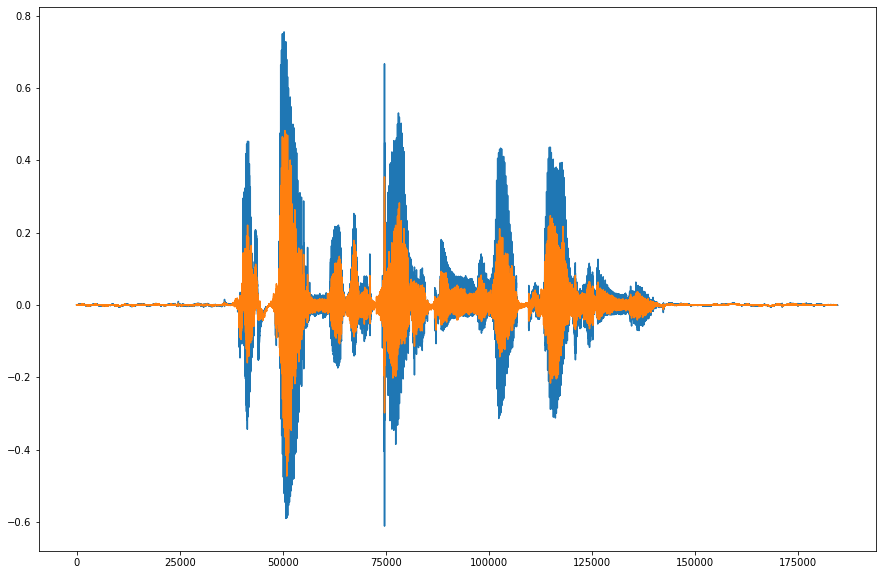

In [25]:
plt.figure(figsize=(15,10))
x = next(iter(train_dl))
plt.plot(x[1][0].T.cpu())
plt.plot(x[0][0].T.cpu())

In [31]:
display(ipd.Audio(x[1][0].squeeze().cpu(), rate=sr));

In [28]:
loss_batch(model, loss_fun, x.to(dev), x.to(dev))

E:\Users\alex\anaconda3\envs\mil\lib\site-packages\torch\nn\modules\loss.py:94: UserWarning: Using a target size (torch.Size([114718, 1, 1])) that is different to the input size (torch.Size([114718, 2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


(0.021436970680952072, 114718)

In [20]:
torch.save(model.state_dict(), "wv.pth")

In [27]:
# x = val_ds[0][0]
tt = x[0][0]
t = tt.squeeze().cpu()
display(ipd.Audio(t, rate=sr));

In [28]:
net = DenoisingWavenet(config)
net.load_state_dict(torch.load("wv.pth"))

<All keys matched successfully>

In [29]:
y = net(tt.unsqueeze(1).cpu()).squeeze(1).detach().numpy()
display(ipd.Audio(y, rate=sr));

In [24]:
import matplotlib.pyplot as plt

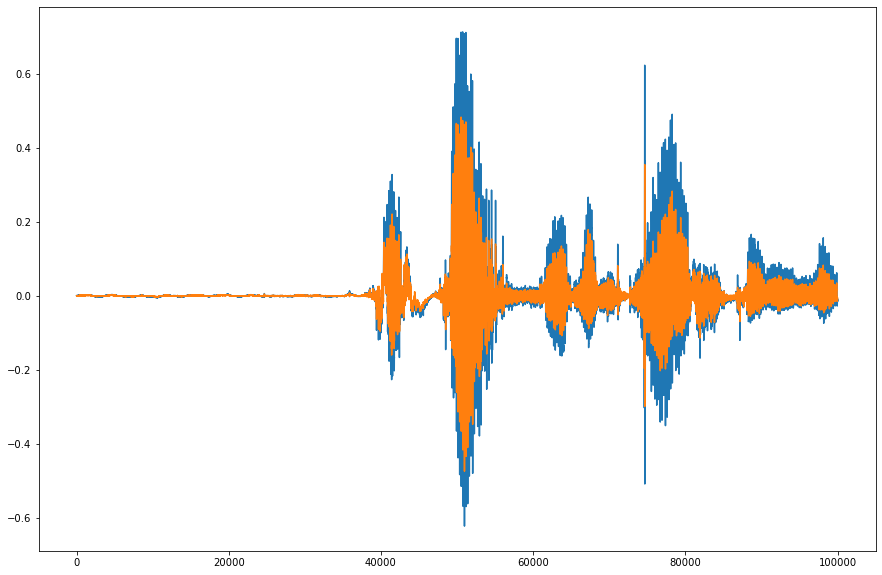

In [30]:
plt.figure(figsize=(15, 10))
# plt.plot(y.T)
plt.plot(y[:,:100000].T)
plt.plot(t[:100000])


In [34]:
x

tensor([[-0.0016, -0.0016, -0.0020,  ...,  0.0009,  0.0005,  0.0010]])

In [35]:
y

array([[-0.00069899, -0.00161357, -0.001977  , ...,  0.00093871,
         0.00055241,  0.00055557]], dtype=float32)